My aggregation pipeline:

In [2]:
import json

# Demonstration of how to load a file that contains secrets without accidentally leaking those secrets
with open('C:\\Users\\musta\\OneDrive\\Documents\\School\\DATA320\\Detecting Outliers\\Mustafa_Secrets.json') as f:
    data = json.load(f)

    # If you want your data to be secure, don't print this variable out!
    # Jupyter will retain a cached version of any printed data and it can be
    # accidentally committed to version control.
    secret_key=data["mongodb"]

# We can safely print the length of the secret key. That won't leak any sensitive information.
print(f"My secret key is {len(secret_key)} characters in length.")

My secret key is 71 characters in length.


In [3]:
import pymongo
import certifi

# Once you have retrieved your connection string from a secrets file, use it here
mongo_connection_string = data['mongodb']

# Connect to the database using known good certificates
client = pymongo.MongoClient(mongo_connection_string, tlsCAFile=certifi.where())

# Fetch the database named "DATA320"
db = client['DATA320']

# Within the database we have "collections". Think of them as tables in SQL.
allCollections = db.list_collection_names()

# Here is the list of collections within my database
print(f"Using MongoDB version {client.server_info()['version']}.")
print(f"This database has the collections {allCollections}")

Using MongoDB version 6.0.11.
This database has the collections ['imDB', 'metacritic', 'imDB_pipeine_view']


In [ ]:
import pandas as pd

# Fetch and transform the imDB data set
imdb = db.imDB.aggregate([
    {
        '$project': {
            'id': '$id', 
            'title': '$title', 
            'runtime': {
                '$convert': {
                    'input': '$runtime', 
                    'to': 'int', 
                    'onError': None
                }
            }, 
            'release_date': {
                '$convert': {
                    'input': '$release_date', 
                    'to': 'date', 
                    'onError': None
                }
            }, 
            'user_rating': {
                '$convert': {
                    'input': '$user_rating', 
                    'to': 'double', 
                    'onError': None
                }
            }, 
            'votes': {
                '$convert': {
                    'input': '$votes', 
                    'to': 'long', 
                    'onError': None
                }
            }, 
            'budget': {
                '$convert': {
                    'input': '$budget', 
                    'to': 'long', 
                    'onError': None
                }
            }, 
            'opening_weekend': {
                '$convert': {
                    'input': '$opening_weekend', 
                    'to': 'long', 
                    'onError': None
                }
            }, 
            'gross_sales': {
                '$convert': {
                    'input': '$gross_sales', 
                    'to': 'long', 
                    'onError': None
                }
            }, 
            'genre': {
                '$map': {
                    'input': {
                        '$split': [
                            '$genres', ','
                        ]
                    }, 
                    'as': 'split_text', 
                    'in': {
                        '$trim': {
                            'input': '$$split_text'
                        }
                    }
                }
            }, 
            'company': {
                '$split': [
                    {'$toString': "$company",},
                    ",",
                ]
            }, 
            'cast': {
                '$map': {
                    'input': {
                        '$split': [
                            '$cast', ','
                        ]
                    }, 
                    'as': 'split_text', 
                    'in': {
                        '$trim': {
                            'input': '$$split_text'
                        }
                    }
                }
            }, 
            'director': {
                '$map': {
                    'input': {
                        '$split': [
                            '$director', ','
                        ]
                    }, 
                    'as': 'split_text', 
                    'in': {
                        '$trim': {
                            'input': '$$split_text'
                        }
                    }
                }
            }, 
            'producer': {
                '$map': {
                    'input': {
                        '$split': [
                            '$producer', ','
                        ]
                    }, 
                    'as': 'split_text', 
                    'in': {
                        '$trim': {
                            'input': '$$split_text'
                        }
                    }
                }
            }, 
            'ratingsTrimmed': {
                '$map': {
                    'input': {
                        '$split': [
                            '$mpaa_rating', '::'
                        ]
                    }, 
                    'as': 'split_text', 
                    'in': {
                        '$trim': {
                            'input': '$$split_text'
                        }
                    }
                }
            }
        }
    }, {
        '$addFields': {
            'release_year': {
                '$year': '$release_date'
            }, 
            'release_month': {
                '$month': '$release_date'
            }, 
            'release_day': {
                '$dayOfMonth': '$release_date'
            }, 
            'mpaa_rating': {
                '$arrayElemAt': [
                    '$ratingsTrimmed', 0
                ]
            }
        }
    }
])

imdb = pd.DataFrame(imdb)
imdb.head()

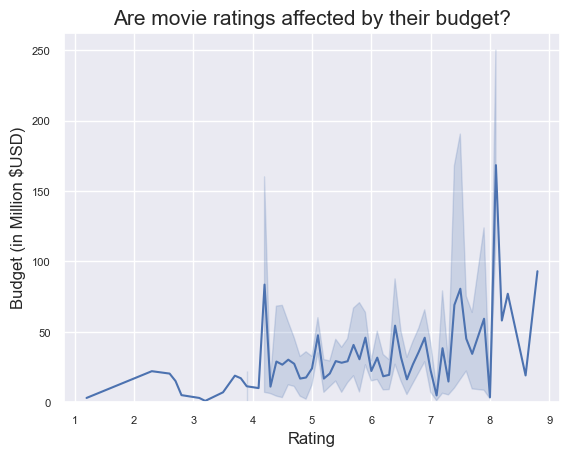

In [64]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Filter for movies released in 2001
imdb_2001 = imdb.loc[(imdb['release_year'] == 2001)]

# Create a basic line chart.
sns.lineplot(data=imdb_2001, x='user_rating', y='budget')
plt.yscale('linear')
plt.ylim(bottom=0)

# Set the y-axis tick formatting to display numbers in hundred of millions
formatter = mticker.FuncFormatter(lambda x, pos: f'{x/1000000:.0f}')
plt.gca().yaxis.set_major_formatter(formatter)


# Add our text.
plt.title('Are movie ratings affected by their budget?', fontsize=15, loc='center')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Budget', fontsize=12)
plt.tick_params(axis='both', labelsize=8)

While there is a discernible upward trend in ratings as we transition from lower to higher budgets, it is important to note that this increase is of a modest nature. The graphical representation of our analysis demonstrates that, with respect to movies released in the year 2001, there exists only a minimal correlation between the budget of a film and its corresponding rating. Consequently, it is reasonable to conclude that a high budget allocation does not inherently guarantee a favorable reception in terms of movie quality.

C:\Users\musta\AppData\Local\Temp\ipykernel_35884\3189669522.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imdb, x="mpaa_rating", y="gross_sales", errorbar=None, palette="viridis")


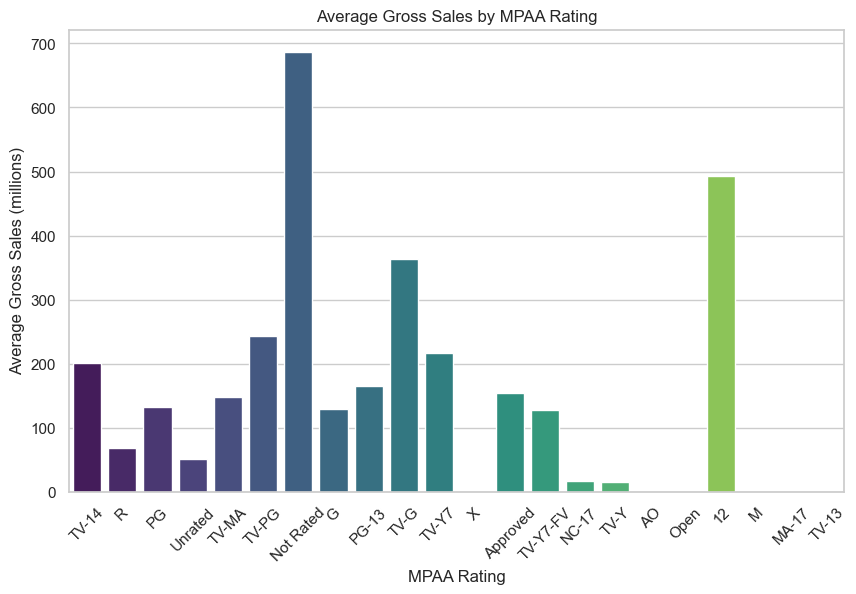

In [107]:
# Create a bar plot to show the average gross sales for each MPAA rating
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=imdb, x="mpaa_rating", y="gross_sales", errorbar=None, palette="viridis")
plt.title("Average Gross Sales by MPAA Rating")
plt.xlabel("MPAA Rating")
plt.ylabel("Average Gross Sales (millions)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Set the y/x-axis tick formatting to display numbers in hundreds of millions
formatter = mticker.FuncFormatter(lambda x, pos: f'{x/1000000:.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

Our study delves into the examination of the influence of MPAA ratings on the market value of films released in the year 2001. Notably, the chart reveals intriguing findings, with the most striking observation being that movies classified with an 'R' rating achieved the second-highest gross sales in the market during that year. Conversely, it is noteworthy that there were no movies rated 'X,' 'AO,' 'Open,' 'M,' 'MA-17,' or 'TV-13' released within this period. Equally intriguing is the revelation that unrated movies, which constituted the highest in gross sales, invite heightened curiosity. This phenomenon may be attributed to the possibility that these unrated movies were primarily non-U.S. releases, thus warranting further investigation.

C:\Users\musta\AppData\Local\Temp\ipykernel_35884\3184886662.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=imdb, y="user_rating", palette="viridis")


([<matplotlib.axis.YTick at 0x1f876ca3d60>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 3.0, '3.0'),
  Text(0, 3.5, '3.5'),
  Text(0, 4.0, '4.0'),
  Text(0, 4.5, '4.5'),
  Text(0, 5.0, '5.0'),
  Text(0, 5.5, '5.5'),
  Text(0, 6.0, '6.0'),
  Text(0, 6.5, '6.5'),
  Text(0, 7.0, '7.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 8.0, '8.0'),
  Text(0, 8.5, '8.5'),
  Text(0, 9.0, '9.0'),
  Text(0, 9.5, '9.5')])

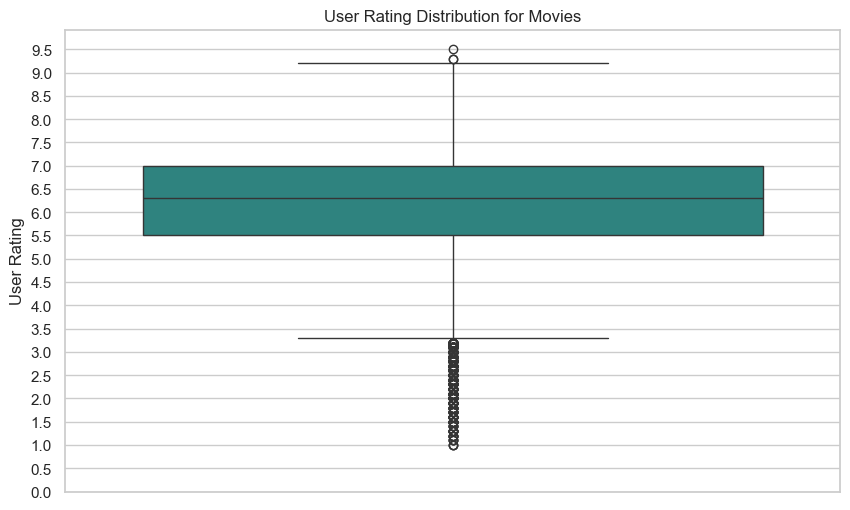

In [123]:
# Create a box plot to show the distribution of user ratings for movies (0 to 10 with increments of 0.1)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data=imdb, y="user_rating", palette="viridis")
plt.title("User Rating Distribution for Movies")
plt.ylabel("User Rating")

# Set y-axis ticks with increments of 0.5
plt.yticks(np.arange(0, 10, 0.5))

The examination of the distribution of user ratings for films released in the year 2001 reveals a median range spanning from approximately 5.5 to 7, with the presence of only two outliers exceeding a rating of 9.0 and a notable number of ratings falling below the 3.5 threshold. The boxplot analysis leads us to a tentative inference that the year 2001 may not have been a particularly favorable period for movie enthusiasts, based on the distribution of user ratings.